<a href="https://colab.research.google.com/github/brunoOnm/app-precificacao/blob/main/Modelo_de_Renda_Treinamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinamento do modelo de renda média

In [ ]:
import pandas as pd

#conexão
import pickle
import redshift

#modelagem e validação
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

from sklearn.linear_model import\
    LinearRegression, Lasso

from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import FunctionTransformer

In [ ]:
df_indicadores = pd.read_excel('dados/base_indicadores.xlsx')

In [ ]:
df_indicadores.estimativa_subsidio = np.power(df_indicadores.estimativa_subsidio,2) 

In [ ]:
produtos_alvo = tuple(df_indicadores.query('safra == "treino"').ID_SAP.dropna().values)

In [ ]:
query_vendas = f''' select 
data_venda
,proposta
,cd_proposta
,nome_empreendimento
,divisao_sap
,cidade
,uf
,tipologia_de_para
--cliente
,cliente_sap
,documento
,cliente
,cli.dt_nascimento
,cli.vl_renda_mensal
,cli.vl_renda_formal
,cli.ds_origem_renda_formal
,cli.vl_renda_informal
,cli.ds_origem_renda_informal
,cli.vl_fgts
,cli.vl_meses_fgts
,cli.fl_possui_financiamento
,cli.nr_filhos
,cli.ds_cargo
,cli.tp_escolaridade
,cli.tp_residencia
,cli.vl_aluguel
,cli.nr_tempo_de_empresa
,cli.nm_empresa
,cli.ds_ramo_atividade_empresa
,cli.fl_possui_automovel
,cli.ds_cpf
,cli.ds_id_sap
,cli.nm_cliente
,cli.ds_telefone
,cli.fl_email_contato
,cli.fl_enviar_material_marketing
,cli.tp_melhor_hr_contato
-- valores
,valor_imovel
,valor_venda
,vl_preco_raso_proposta_prp
,valor_tcd
,parcela_aprovada
,fator_social
,"faixa_1,5"
,total_itbi
,pre_chaves_itbi_
,pos_chaves_itbi_
,total_geral_preco_raso
,total_geral_venda
,premiada_tenda_
,total_geral_sem_premiada
,preco_nominal_bp
,preco_raso_bp
,renda_bruta_familiar
,ato_entrada
,pre_chaves
,pre_chaves_intermediaria
,pos_chaves
,financiamento
,subsidio
,fgts
,pre_chaves_itbi
,pre_chaves_intermediaria_itbi
,pos_chaves_itbi
,premiada_tenda
from
vendas.vw_base_dash_vendas v
left join vendas.t_clientes cli
	on  v.cliente_sap = cli.ds_id_sap 
where data_venda is not null
-- and data_venda  > '20190101'
and divisao_sap in {produtos_alvo}
and data_venda  BETWEEN '20190101' AND '20210228'
'''

In [ ]:
df_vendas = redshift.df_query(query_vendas)

In [ ]:
# limpeza da base
df_vendas = df_vendas.query('tipologia_de_para !=  "PNE"')
mask_vendas = (df_vendas.renda_bruta_familiar > 990) & (df_vendas.renda_bruta_familiar < 10000)
df_vendas = df_vendas.loc[mask_vendas]

# Produtos com mais de 
qnt_vendas = df_vendas.groupby('nome_empreendimento',as_index= False).agg({'proposta':'count'}).sort_values(by='proposta')
produtos_filtro = list(qnt_vendas[qnt_vendas.proposta >= 80].nome_empreendimento)
df_vendas = df_vendas.loc[df_vendas.query(f'nome_empreendimento =={produtos_filtro}').index]

In [ ]:
#Parametros do gridsearch para a regularização 
corte_renda = np.arange(2000,4600,100)
param_grid = {'alpha': 10**np.linspace(-3, 3, 100)}

In [ ]:
corte = 2600
df_vendas['flag_bojo'] = np.where(df_vendas['renda_bruta_familiar'] < corte,1,0)
df_proporcao = df_vendas.groupby(['nome_empreendimento','divisao_sap'],as_index=False).agg({'flag_bojo':'sum',
                                                     'proposta': 'count'})

df_proporcao['prop_bojo'] = df_proporcao.flag_bojo / df_proporcao.proposta
df_proporcao['prop_cauda']  = 1- df_proporcao['prop_bojo'] 

#define valores medios para o bojo e cauda
df_parametros = pd.pivot_table(df_vendas, values='renda_bruta_familiar', index=['nome_empreendimento','divisao_sap'],
            columns=['flag_bojo'], aggfunc=np.mean).reset_index()

df_parametros.rename(columns= {0:'Cauda',1:'Bojo'}, inplace= True)


In [ ]:
df_grupo_rendas =  df_parametros.merge(df_proporcao[['divisao_sap','prop_bojo','prop_cauda']],
            on = 'divisao_sap')

In [ ]:
df_rendas_modelo = df_indicadores.query('safra == "treino" ').merge(df_grupo_rendas[['divisao_sap','nome_empreendimento','Cauda','prop_cauda','Bojo','prop_bojo' ]],
                       how = 'inner',
                       left_on='ID_SAP',
                       right_on='divisao_sap')

In [ ]:
colunas_renda = ['Cauda', 'prop_cauda', 'Bojo', 'prop_bojo' ,'nome_de_para','rmb2' , 'capital' , 'ufSP' , 'avaliacao','estimativa_subsidio', 'uf']

exploratorias_bojo = ['Saúde_ate_3km_influente', 'parada de ônibus_ate_5km_influente','rmb2' , 'capital','ufSP' , 'avaliacao','estimativa_subsidio']
places_bojo = ['Saúde_ate_3km_influente', 'parada de ônibus_ate_5km_influente']
exploratorias_cauda = ['Saúde_ate_3km_influente', 'Saúde_ate_5km_influente', 'parada de ônibus_ate_5km_influente', 'parada de ônibus_maior_5km_influente','rmb2' , 'capital','ufSP' , 'avaliacao','estimativa_subsidio']
places_cauda = ['Saúde_ate_3km_influente', 'Saúde_ate_5km_influente', 'parada de ônibus_ate_5km_influente', 'parada de ônibus_maior_5km_influente']

In [ ]:
df_model = df_rendas_modelo[colunas_renda + places_cauda]
df_model.drop(columns=['nome_de_para'],inplace =True)
df_validacao =  df_model.copy()
df_model.drop(columns= ['uf','prop_cauda','prop_bojo'], inplace = True)

C:\Users\bmoreira\Anaconda3\lib\site-packages\pandas\core\frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
#Modeling bojo
# split into inputs and outputs
X, y = df_model[exploratorias_bojo], df_model['Bojo']
#define cross-validation method to use
cv = LeaveOneOut()
#build multiple linear regression model
linear_model  = LinearRegression()
#Apply log in vars
transformer = FunctionTransformer(np.log1p, validate=True)
clf_bojo = make_pipeline(transformer, linear_model)
clf_bojo.fit(X, y)

Pipeline(memory=None,
         steps=[('functiontransformer',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<ufunc 'log1p'>, inv_kw_args=None,
                                     inverse_func=None, kw_args=None,
                                     validate=True)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [ ]:
#Results bojo
df_validacao['predict_bojo'] =  cross_val_predict(clf_bojo, X, y, cv=len(X), n_jobs=-1)
df_validacao['erro_bojo'] = df_validacao['Bojo']- df_validacao.predict_bojo


In [ ]:
# split into inputs and outputs
X, y = df_model.dropna(subset=['Cauda'], axis = 0)[exploratorias_cauda], df_model.dropna(subset=['Cauda'], axis = 0)['Cauda']
#define cross-validation method to use
cv = LeaveOneOut()
#build multiple linear regression model
#model = LinearRegression()

model    = GridSearchCV(Lasso(),
                        param_grid,
                        n_jobs=-1,
                        scoring='neg_root_mean_squared_error')

#Apply log in vars
transformer = FunctionTransformer(np.log1p, validate=True)
clf_cauda = make_pipeline(transformer, model)

clf_cauda.fit(X, y)

#Results
df_validacao.loc[df_validacao.Cauda.notnull(),'predict_cauda'] =  cross_val_predict(clf_cauda, X, y, cv=len(X), n_jobs=-1)
df_validacao.loc[df_validacao.Cauda.notnull(),'erro_cauda'] = df_validacao.loc[df_validacao.Cauda.notnull(),'Cauda']- df_validacao.loc[df_validacao.Cauda.notnull(),'predict_cauda']

df_validacao['erro_cauda'].fillna(0,inplace = True)
df_validacao['predict_cauda'].fillna(0,inplace = True)
df_validacao['erro_ponderado'] = (df_validacao.prop_cauda * df_validacao.erro_cauda) + (df_validacao.prop_bojo * df_validacao.erro_bojo)



In [ ]:
#resultados 
erro_bojo =  np.mean(abs(df_validacao.erro_bojo))
erro_cauda =  np.mean(abs(df_validacao.erro_cauda))
erro_ponderado =  np.mean(abs(df_validacao['erro_ponderado']))
std_erro =  np.std(abs(df_validacao['erro_ponderado']))
df_aux = pd.DataFrame(data= [[corte,erro_bojo,erro_cauda,erro_ponderado,std_erro]],columns=['corte','erro_bojo','erro_cauda','erro_ponderado','std_erro'])

print('erro ponderado: R$ ', erro_ponderado )
print('std erro ponderado:  R$', std_erro)

erro ponderado: R$  71.84243572950515
std erro ponderado:  R$ 66.73003195236902


In [ ]:
import seaborn as sns

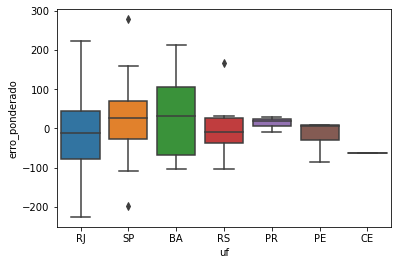

In [ ]:
sns.boxplot(x = df_validacao.uf , y = df_validacao.erro_ponderado)

In [ ]:
#resultados 
erro_bojo =  np.mean(abs(df_validacao.erro_bojo))
erro_cauda =  np.mean(abs(df_validacao.erro_cauda))
erro_ponderado =  np.mean(abs(df_validacao['erro_ponderado']))
std_erro =  np.std(abs(df_validacao['erro_ponderado']))
df_aux = pd.DataFrame(data= [[corte,erro_bojo,erro_cauda,erro_ponderado,std_erro]],columns=['corte','erro_bojo','erro_cauda','erro_ponderado','std_erro'])

print('erro ponderado: R$ ', erro_ponderado )
print('std erro ponderado:  R$', std_erro)

erro ponderado: R$  71.45385422218921
std erro ponderado:  R$ 66.99568431318295


# modelo para proporção

In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics
import statsmodels.api as sm

In [ ]:
df_model = df_rendas_modelo[['ID_SAP', 'nome_de_para', 'safra', 'uf','Cauda','Bojo', 'prop_bojo','estimativa_subsidio', 'avaliacao', 'rmb2', 'ufSP', 'capital', 'Saúde_ate_3km_influente',
       'Saúde_ate_5km_influente', 'parada de ônibus_ate_5km_influente','parada de ônibus_maior_5km_influente']]
df_validacao_prop =  df_model.copy()
df_model.drop(columns= ['ID_SAP', 'nome_de_para', 'safra', 'uf'], inplace = True)

C:\Users\bmoreira\Anaconda3\lib\site-packages\pandas\core\frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
#Modeling bojo
# split into inputs and outputs
X, y = df_model[['Cauda','Bojo','estimativa_subsidio', 'avaliacao', 'rmb2', 'ufSP', 'capital', 'Saúde_ate_3km_influente', 'Saúde_ate_5km_influente', 'parada de ônibus_ate_5km_influente','parada de ônibus_maior_5km_influente']], df_model['prop_bojo']

In [ ]:
binom_glm = sm.GLM(y, X, family=sm.families.Binomial())
binom_results = binom_glm.fit()

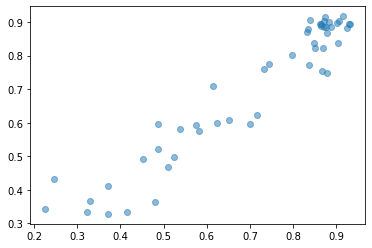

In [ ]:
plt.plot(y, binom_results.predict(X), 'o', alpha=0.5);

In [ ]:
binom_results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Generalized linear model
===================================================================================
Model:                     GLM                     AIC:                   57.0426  
Link Function:             logit                   BIC:                   -151.5612
Dependent Variable:        prop_bojo               Log-Likelihood:        -17.521  
Date:                      2021-03-30 12:12        LL-Null:               -22.311  
No. Observations:          50                      Deviance:              1.0077   
Df Model:                  10                      Pearson chi2:          0.976    
Df Residuals:              39                      Scale:                 1.0000   
Method:                    IRLS                                                    
-----------------------------------------------------------------------------------
                                      Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-----------------------------------------------------------------------------------
Cauda                                -0.0007   0.0021 -0.3260 0.7444 -0.0048 0.0034
Bojo                                 -0.0033   0.0048 -0.7004 0.4837 -0.0126 0.0060
estimativa_subsidio                   0.0000   0.0000  0.2259 0.8213 -0.0000 0.0000
avaliacao                            -0.0000   0.0000 -0.1712 0.8641 -0.0001 0.0001
rmb2                                  0.0016   0.0016  1.0292 0.3034 -0.0015 0.0047
ufSP                                 -0.0789   1.4891 -0.0530 0.9578 -2.9975 2.8398
capital                              -0.1941   1.1599 -0.1674 0.8671 -2.4675 2.0792
Saúde_ate_3km_influente              -0.1688   1.1404 -0.1480 0.8823 -2.4039 2.0662
Saúde_ate_5km_influente               0.4467   1.0518  0.4247 0.6710 -1.6148 2.5083
parada de ônibus_ate_5km_influente    0.2697   2.0143  0.1339 0.8935 -3.6783 4.2176
parada de ônibus_maior_5km_influente -0.3490   1.6575 -0.2106 0.8332 -3.5977 2.8997
===================================================================================

"""

In [ ]:
metrics.mean_absolute_error(df_validacao_prop.prop_bojo, binom_results.predict(X))

0.046574979850814484

In [ ]:
metrics.r2_score(df_validacao_prop.prop_bojo, binom_results.predict(X))

0.9148958680906139

In [ ]:
metrics.mean_absolute_error( df_validacao_prop.renda_ponderada_real , (binom_results.predict(X) *  df_validacao_prop.Bojo ) +  ((1-binom_results.predict(X)) *  df_validacao_prop.Cauda ))

70.56922014589757

In [ ]:
df_validacao_prop.predict_prop_bojo = binom_results.predict(X)

In [ ]:
df_validacao_prop['renda_ponderada_estimada']  =  (df_validacao_prop.predict_prop_bojo *  df_validacao_prop.Bojo ) +  ((1-df_validacao_prop.predict_prop_bojo) *  df_validacao_prop.Cauda )

In [ ]:
df_validacao_prop['erro_prop_bojo'] =  df_validacao_prop.predict_prop_bojo - df_validacao_prop.prop_bojo

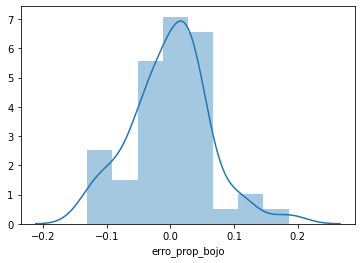

In [ ]:
sns.distplot(df_validacao_prop['erro_prop_bojo'])

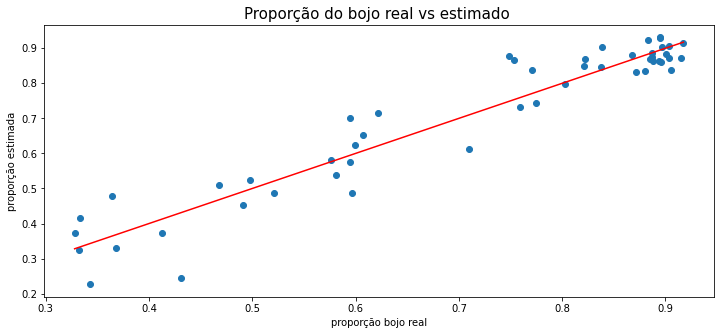

In [ ]:
plt.subplots(1,figsize=(12,5))
plt.scatter((df_validacao_prop.predict_prop_bojo ), df_validacao_prop.prop_bojo )
range = [( df_validacao_prop.predict_prop_bojo).min(), df_validacao_prop.predict_prop_bojo.max()]
plt.plot(range, range, 'red')
plt.xlabel('proporção bojo real')
plt.ylabel('proporção estimada')
plt.title("Proporção do bojo real vs estimado ", size=15)
plt.show();

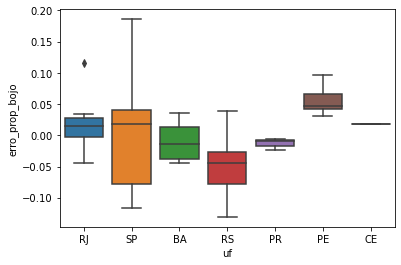

In [ ]:
sns.boxplot(y = df_validacao_prop.erro_prop_bojo,  x = df_validacao_prop.uf)

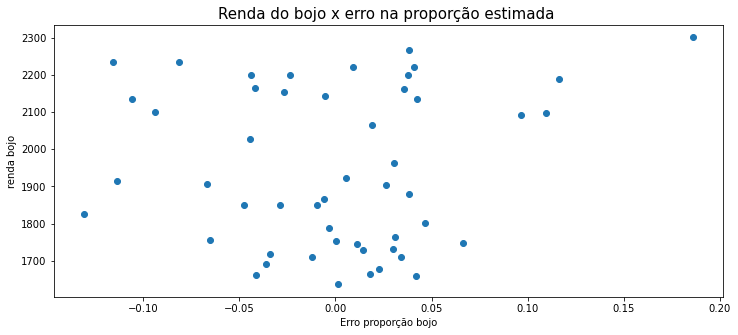

In [ ]:
plt.subplots(1,figsize=(12,5))
plt.scatter(x= df_validacao_prop.erro_prop_bojo, y= df_validacao_prop.Bojo )
plt.xlabel('Erro proporção bojo')
plt.ylabel('renda bojo')
plt.title("Renda do bojo x erro na proporção estimada ", size=15)
plt.show();

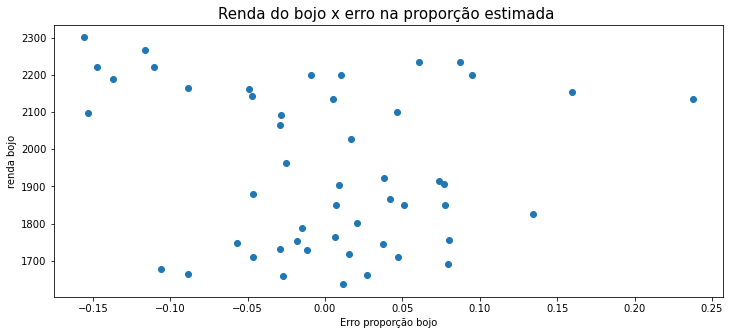

In [ ]:
plt.subplots(1,figsize=(12,5))
plt.scatter(x= df_validacao_prop.erro_prop_bojo, y= df_validacao_prop.Bojo )
plt.xlabel('Erro proporção bojo')
plt.ylabel('renda bojo')
plt.title("Renda do bojo x erro na proporção estimada ", size=15)
plt.show();

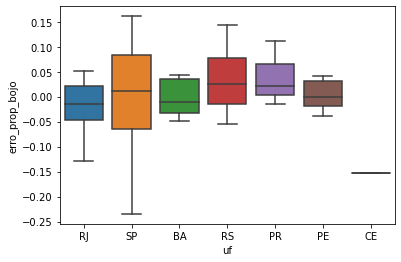

In [ ]:
sns.boxplot(y = df_validacao_prop.erro_prop_bojo,  x = df_validacao_prop.uf)

In [ ]:
metrics.mean_squared_error(df_validacao_prop.prop_bojo, df_validacao_prop.predict_prop_bojo)

0.006428461591607172

In [ ]:
metrics.mean_absolute_error(df_validacao_prop.prop_bojo, df_validacao_prop.predict_prop_bojo)

0.0618976540637077

In [ ]:
metrics.r2_score(df_validacao_prop.prop_bojo, df_validacao_prop.predict_prop_bojo)

0.8533043075933737

In [ ]:
clf_bojo.named_steps['linearregression'].intercept_

16.80590985772603

In [ ]:
pd.DataFrame( list(zip( clf_bojo.named_steps['linearregression'].coef_, X.columns)))

,0,1
0,-0.398926,Cauda
1,-0.973692,Bojo
2,0.041803,estimativa_subsidio
3,-0.383471,avaliacao
4,-0.195554,rmb2
5,0.127901,ufSP
6,-0.042492,capital
7,-0.007658,Saúde_ate_3km_influente
8,0.101269,Saúde_ate_5km_influente
9,0.100316,parada de ônibus_ate_5km_influente


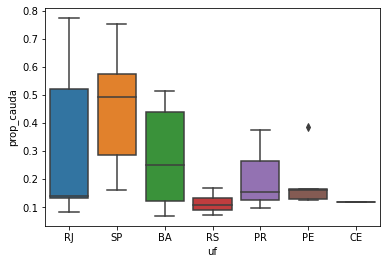

In [ ]:
sns.boxplot(y = df_rendas_modelo.prop_cauda,  x = df_rendas_modelo.uf)

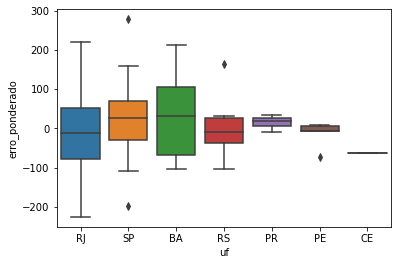

In [ ]:
sns.boxplot(x = df_validacao.uf , y = df_validacao.erro_ponderado)

In [ ]:
df_validacao_prop['renda_ponderada_real'] =(df_validacao_prop.prop_bojo * df_validacao_prop.Bojo) +  ((1-df_validacao_prop.prop_bojo) * df_validacao_prop.Cauda) 
df_validacao_prop['renda_ponderada_estimada']  =  (df_validacao_prop.predict_prop_bojo *  df_validacao_prop.Bojo ) +  ((1-df_validacao_prop.predict_prop_bojo) *  df_validacao_prop.Cauda )

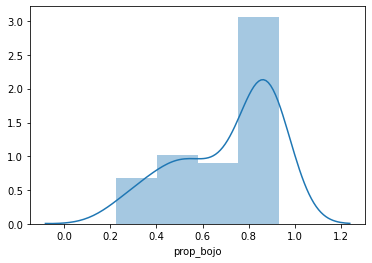

In [ ]:
sns.distplot(df_validacao_prop.prop_bojo)

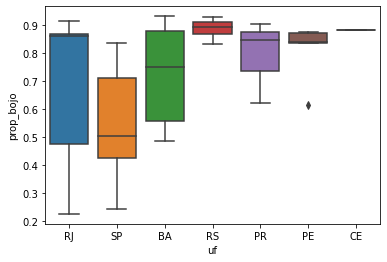

In [ ]:
sns.boxplot(x = df_validacao_prop.uf, y =df_validacao_prop.prop_bojo)

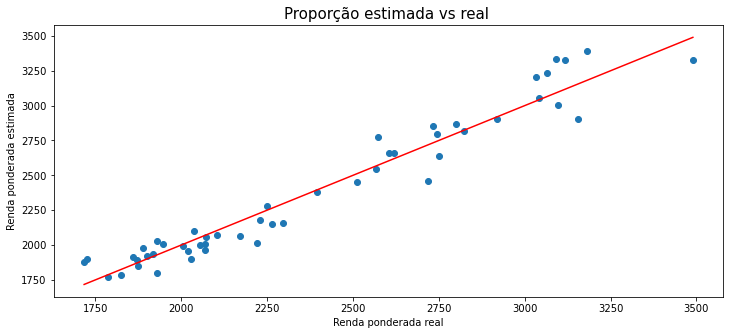

In [ ]:
plt.subplots(1,figsize=(12,5))
plt.scatter((df_validacao_prop.renda_ponderada_estimada ), df_validacao_prop.renda_ponderada_real )
range = [( df_validacao_prop.renda_ponderada_estimada).min(), df_validacao_prop.renda_ponderada_estimada.max()]
plt.plot(range, range, 'red')
plt.xlabel('Renda ponderada real')
plt.ylabel('Renda ponderada estimada')
plt.title("Proporção estimada vs real ", size=15)
plt.show();

In [ ]:
df_validacao_prop.predict_prop_bojo.describe()

count    50.000000
mean      0.705624
std       0.193348
min       0.327578
25%       0.533861
50%       0.764901
75%       0.875793
max       0.970815
Name: predict_prop_bojo, dtype: float64

In [ ]:
df_validacao_prop.columns

Index(['ID_SAP', 'nome_de_para', 'safra', 'uf', 'Cauda', 'Bojo', 'prop_bojo',
       'estimativa_subsidio', 'avaliacao', 'rmb2', 'ufSP', 'capital',
       'Saúde_ate_3km_influente', 'Saúde_ate_5km_influente',
       'parada de ônibus_ate_5km_influente',
       'parada de ônibus_maior_5km_influente', 'predict_prop_bojo',
       'erro_prop_bojo', 'renda_ponderada_real', 'renda_ponderada_estimada'],
      dtype='object')

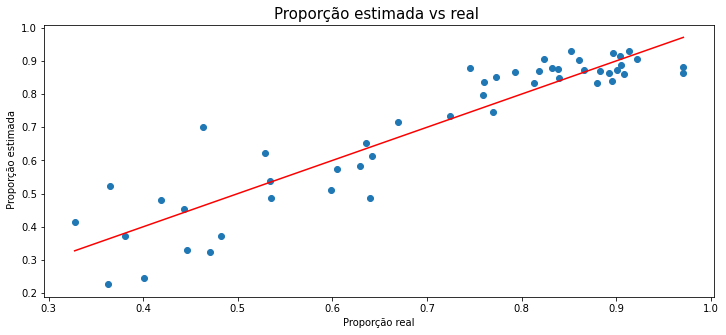

In [ ]:
plt.subplots(1,figsize=(12,5))
plt.scatter((df_validacao_prop.predict_prop_bojo ), df_validacao_prop.prop_bojo )
range = [( df_validacao_prop.predict_prop_bojo).min(), df_validacao_prop.predict_prop_bojo.max()]
plt.plot(range, range, 'red')
plt.xlabel('Proporção real')
plt.ylabel(' Proporção estimada')
plt.title("Proporção estimada vs real ", size=15)
plt.show();

In [ ]:
metrics.mean_absolute_error( df_validacao_prop.renda_ponderada_real , (df_validacao_prop.predict_prop_bojo *  df_validacao_prop.Bojo ) +  ((1-df_validacao_prop.predict_prop_bojo) *  df_validacao_prop.Cauda ))

92.89257065207441

In [ ]:
# Save for later
with open('Dados/clf_cauda.pickle', 'wb') as to_write:
    pickle.dump(clf_cauda, to_write)
    
with open('Dados/clf_bojo.pickle', 'wb') as to_write:
    pickle.dump(clf_bojo, to_write)

In [ ]:
with open('Dados/binom_results.pickle', 'wb') as to_write:
    pickle.dump(binom_results, to_write)   